# Preparing Dataset & Dependencies

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.random.set_seed(1234)
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import math
import pydot
import matplotlib.pyplot as plt
import graphviz

In [ ]:
def preprocess_sentence(sentence):
  sentence = sentence.replace('_comma_', ',')
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = re.sub(r"  ","",sentence)
  sentence = sentence.strip()
  return sentence

MAX_SENTENCE_LENGTH = 128

In [ ]:
df = pd.read_csv("D:\skripsi-sultin\data\datasets_skripsi_sultan_new - Copy.csv")

In [ ]:
##load convo from df and concenatate

def load_conversations_from_csv():
    inputs, outputs = [], []

    for index, row in df.iterrows():
        ip = preprocess_sentence(row['question'])
        op = preprocess_sentence(row['response'].replace('\n', ' '))

        if len(ip.split())>MAX_SENTENCE_LENGTH:
            continue

        outputs.append(op)
        inputs.append(ip)

    return inputs, outputs

questions, answers = load_conversations_from_csv()

In [ ]:
print(len(questions))
print(len(answers))

500
500


In [ ]:
print('Question: ' + questions[41])
print('Answer: ' + answers[41])

Question: Bagaimana cara membangun kembali hubungan yang baik dengan kedua orang tua setelah mereka berpisah ?
Answer: Setelah perceraian , hubungan dengan kedua orang tua mungkin terasa berbeda , tetapi bukan berarti keterikatan yang sehat tidak bisa terjalin . Cobalah untuk membangun kembali hubungan dengan langkah kecil , seperti menghabiskan waktu bersama dalam suasana yang nyaman atau mengungkapkan perasaan Anda secara terbuka . Ingatlah bahwa Anda tidak harus memilih salah satu orang tua kedua hubungan tersebut tetap penting dan bisa berkembang dengan cara yang unik . Dengan pendekatan yang penuh pengertian , Anda dapat menemukan cara untuk menjaga kedekatan tanpa merasa terjebak dalam konflik masa lalu .


In [ ]:
len(questions)
len(answers)

500

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('Tokenized sample question: {}'.format(tokenizer.encode(questions[27])))


Tokenized sample question: [51, 134, 98, 257, 64, 5, 18, 1, 635, 583, 274, 13]


In [ ]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # Tokenize sentences
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # Check tokenized sentence max length
        if len(sentence1) <= MAX_SENTENCE_LENGTH and len(sentence2) <= MAX_SENTENCE_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # Pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_SENTENCE_LENGTH, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_SENTENCE_LENGTH, padding='post'
    )

    # Convert to numpy arrays
    return np.array(tokenized_inputs, dtype=np.int32), np.array(tokenized_outputs, dtype=np.int32)


# Ensure questions & answers contain raw text before passing them in
questions_raw, answers_raw = questions, answers
questions, answers = tokenize_and_filter(questions_raw, answers_raw)

print("Tokenized questions shape:", questions.shape)
print("Tokenized answers shape:", answers.shape)


Tokenized questions shape: (500, 128)
Tokenized answers shape: (500, 128)


In [ ]:
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 2462
Number of samples: 500


In [ ]:
# prompt: save tokenizer

tokenizer.save_to_file('tokenizer_vocab')


In [ ]:
BATCH_SIZE = 8
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': tf.convert_to_tensor(questions, dtype=tf.int32),
        'dec_inputs': tf.convert_to_tensor(answers[:, :-1], dtype=tf.int32)
    },
    tf.convert_to_tensor(answers[:, 1:], dtype=tf.int32)  # <-- Not a dict
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

print("Dataset element spec:", dataset.element_spec)


Dataset element spec: ({'inputs': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 127), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 127), dtype=tf.int32, name=None))


In [ ]:
print(dataset)

<_PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 127), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 127), dtype=tf.int32, name=None))>


# Attention

In [ ]:
# Function = To compute the attention output given query, key, and value matrices,
# optionally applying a mask to ignore irrelevant tokens (e.g., padding or future tokens in decoding).

def scaled_dot_product_attention(query, key, value, mask=None):

  # Ensure all input tensors are in the same datatype (float32) for consistency and safe numerical operations.
  # Step 1: Ensure tensors are float32
  """Calculate the attention weights."""
  query = tf.cast(query, tf.float32)
  key = tf.cast(key, tf.float32)
  value = tf.cast(value, tf.float32)
  print(f"Query shape: {query.shape}")
  print(f"Key shape: {key.shape}")
  print(f"Value shape: {value.shape}")

  # This computes the raw attention scores by taking the dot product between query
  # and the transpose of key. The result tells you how much each word should attend to every other word.
  # Step 2: Q @ K^T
  matmul_qk = tf.matmul(query, key, transpose_b=True)
  print(f"\nQ × Kᵀ shape: {matmul_qk.shape}")


  # This scales down the attention scores by the square root of the key dimension to avoid extremely large values, which can destabilize training.
  # Step 3: Scale by sqrt(depth)
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)
  print("Scaled logits shape:", logits.shape)

  # If a mask is provided (e.g., for padding or future tokens),
  # it adds a large negative value (-1e9) to the masked positions so that their softmax becomes near-zero, effectively ignoring them.
  # Step 4: Add mask (if provided)
  if mask is not None:
    logits += (mask * -1e9)
    print("Applied mask.")

  # Converts the scaled scores into normalized attention weights.
  # The axis=-1 means softmax is applied across the last dimension (i.e., over all keys for each query).
  # Step 5: Softmax to get attention weights
  attention_weights = tf.nn.softmax(logits, axis=-1)
  print("Attention weights shape:", attention_weights.shape)

  #Computes the final attention output by taking the weighted sum of value vectors,
  #where the weights come from the attention scores. This produces a new representation that focuses on the most relevant parts of the input.
  # Step 6: Attention weights @ V
  output = tf.matmul(attention_weights, value)
  print("Final output shape:", output.shape)

  return output

In [ ]:
# Simulated input (batch_size=1, seq_len=6, d_model=512)
batch_size = 1
seq_len = 6
d_model = 512

q = tf.random.uniform((batch_size, seq_len, d_model))  # shape: (1, 6, 512)
k = tf.random.uniform((batch_size, seq_len, d_model))  # shape: (1, 6, 512)
v = tf.random.uniform((batch_size, seq_len, d_model))  # shape: (1, 6, 512)

# Apply attention
output = scaled_dot_product_attention(q, k, v)

print("\nFinal attention output (values only shown truncated):")
print(output.numpy()[0][:2])  # Print only first 2 output vectors for brevity

Query shape: (1, 6, 512)
Key shape: (1, 6, 512)
Value shape: (1, 6, 512)

Q × Kᵀ shape: (1, 6, 6)
Scaled logits shape: (1, 6, 6)
Attention weights shape: (1, 6, 6)
Final output shape: (1, 6, 512)

Final attention output (values only shown truncated):
[[0.45498696 0.4432221  0.39133194 ... 0.38996    0.54827297 0.72887117]
 [0.44566947 0.4468937  0.37181562 ... 0.38027588 0.520456   0.7100762 ]]


In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers, Transforms the inputs into Q, K, and V vectors.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # Apply scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads, Concatenate all heads back
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

# Transformer
Masking

In [ ]:
# This function generates a padding mask used in Transformer models to prevent the model from attending to padding tokens (value 0) during training or inference.
# Padding mask: Masks out padding tokens (0) so the model doesn't pay attention to them.
def create_padding_mask(x):
  #
  mask = tf.cast(tf.math.equal(x, 0), tf.float32) #This returns a boolean tensor where each True indicates a padding token (0).
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
#This is a batch of 2 sequences (batch size = 2), each of length 5. 0 is used as the padding token.
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0],
                                       [0, 0, 0, 4, 5]])))
# 2: batch size (2 sequences)
# 1: broadcast over all attention heads
# 1: broadcast over all query positions
# 5: sequence length (so model knows which positions to mask)

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


In [ ]:
# Look-ahead mask: Prevents the decoder from "cheating" by looking at future tokens during training
# Combines look-ahead and padding masking This ensures that:
# The decoder doesn't peek into future tokens.
# Padding tokens are also masked out.
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]  #Get Sequence Length
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
#  [[0. 1. 1. 1. 1.]
#  [0. 0. 1. 1. 1.]
#  [0. 0. 0. 1. 1.]
#  [0. 0. 0. 0. 1.]
#  [0. 0. 0. 0. 0.]]

#  Combine Both Masks
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))
# 1	batch size (only 1 input sequence)
# 1	number of attention heads
# 5	query positions (i.e., where we are attending from)
# 5	key positions (i.e., where we are attending to)

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


Positional Encoding

In [ ]:
# Transformers don't have recurrence or convolution, so they lack any built-in notion of token order.
# To fix this, we inject position information into input embeddings using sinusoidal functions.
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model
        )

        # Apply sin to even indices in the array
        sines = tf.math.sin(angle_rads[:, 0::2])

        # Apply cos to odd indices in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        # Make sure inputs are dense tensors
        if isinstance(inputs, tf.SparseTensor):
            inputs = tf.sparse.to_dense(inputs)

        # Add positional encoding
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

    def compute_output_shape(self, input_shape):
        return input_shape

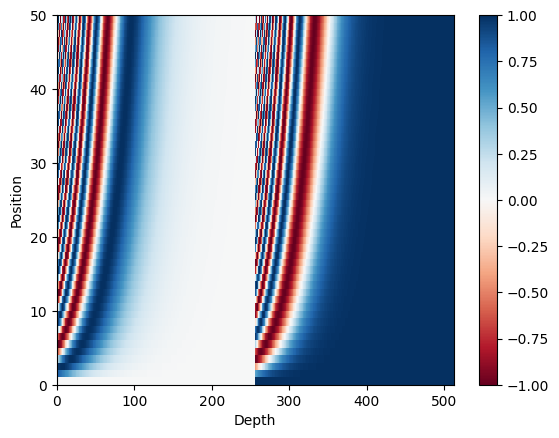

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Encoder Layer
Each encoder layer consists of sublayers:



1.   Multi-head attention (with padding mask)
2.   2 dense layers followed by dropout




In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Multi-head attention
    attention = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=d_model // num_heads, dropout=dropout
    )(
        query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
    )

    # Add & normalize
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed-forward network
    outputs = tf.keras.layers.Dense(units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(d_model)(outputs)

    # Add & normalize
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
sample_encoder_layer = encoder_layer(
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_encoder_layer")

tf.keras.utils.plot_model(
    sample_encoder_layer,
    to_file='encoder_layer.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'  # Top to Bottom layout
)


# Encoder
The Encoder consist of


1.   Input Embedding
2.   Positional Encoding
3.   num_layers encoder layers




In [ ]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Make sure we're using dense embeddings
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # Add positional encoding
    positional_encoding = PositionalEncoding(vocab_size, d_model)
    outputs = positional_encoding(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)

    # Stack encoder layers
    for i in range(num_layers):
        enc_layer = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f"encoder_layer_{i}"
        )
        outputs = enc_layer([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
sample_encoder = encoder(
    vocab_size=8515,
    num_layers=2,
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_encoder")

tf.keras.utils.plot_model(
   sample_encoder, to_file='encoder.png', show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


# Decoder Layer


1.  Masked multi-head attention (with look ahead mask and padding mask)

2.  Multi-head attention (with padding mask). value and key receive the encoder output as inputs. query receives the output from the masked multi-head attention sublayer.
3. 2 dense layers followed by dropout



In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)


Query shape: (None, 8, None, 32)
Key shape: (None, 8, None, 32)
Value shape: (None, 8, None, 32)

Q × Kᵀ shape: (None, 8, None, None)
Scaled logits shape: (None, 8, None, None)
Applied mask.
Attention weights shape: (None, 8, None, None)
Final output shape: (None, 8, None, 32)
Query shape: (None, 8, None, 32)
Key shape: (None, 8, None, 32)
Value shape: (None, 8, None, 32)

Q × Kᵀ shape: (None, 8, None, None)
Scaled logits shape: (None, 8, None, None)
Applied mask.
Attention weights shape: (None, 8, None, None)
Final output shape: (None, 8, None, 32)
Query shape: (None, 8, None, 32)
Key shape: (None, 8, None, 32)
Value shape: (None, 8, None, 32)

Q × Kᵀ shape: (None, 8, None, None)
Scaled logits shape: (None, 8, None, None)
Applied mask.
Attention weights shape: (None, 8, None, None)
Final output shape: (None, 8, None, 32)
Query shape: (None, 8, None, 32)
Key shape: (None, 8, None, 32)
Value shape: (None, 8, None, 32)

Q × Kᵀ shape: (None, 8, None, None)
Scaled logits shape: (None, 8, 

# Decoder


1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers



In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [ ]:
sample_decoder = decoder(
    vocab_size=8515,
    num_layers=2,
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

# Transformers
Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs={'inputs': inputs, 'dec_inputs': dec_inputs}, outputs=outputs, name=name)

In [ ]:
sample_transformer = transformer(
    vocab_size=8515,
    num_layers=2,
    units=512,
    d_model=256,
    num_heads=8,
    dropout=0.1,
    name="our_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

# Train Model
Initialize model

# **Loss function**
Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.


In [ ]:
def loss_function(y_true, y_pred):
  # Reshapes y_true (true labels) to match the shape of y_pred.
    y_true = tf.reshape(y_true, shape=(-1, MAX_SENTENCE_LENGTH - 1))

  # Computes the cross-entropy loss for each token
  # reduction='none' means we’ll compute individual losses for each token without averaging.
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

  # Creates a mask for non-padding tokens.
  # Padding tokens (0) are ignored.
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
  # Averages all the non-zero losses into a single scalar value.
    return tf.reduce_mean(loss)

# Custom learning rate
Use the Adam optimizer with a custom learning rate scheduler

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    # Cast 'step' to tf.float32 before applying tf.math.rsqrt
    step = tf.cast(step, tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

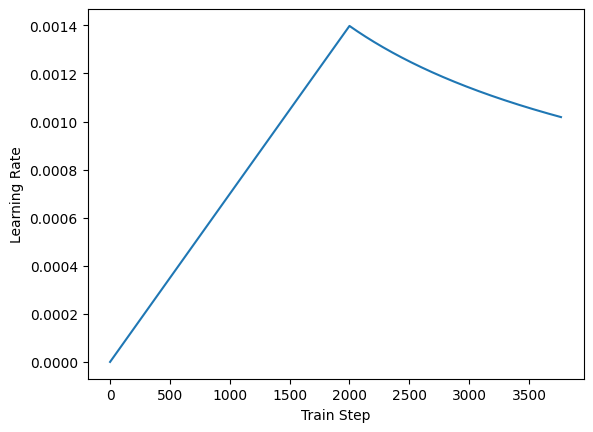

In [ ]:
sample_learning_rate = CustomSchedule(d_model=256)

plt.plot(sample_learning_rate(tf.range(3768, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")


# Compile Model

In [ ]:
import tensorflow as tf
import math

def perplexity(real, pred):
  # Reshape to match the shape of predictions.
    real = tf.reshape(real, shape=(-1, MAX_SENTENCE_LENGTH - 1))
  # Uses the previously defined loss function.
    loss = loss_function(real, pred)
    loss = tf.cast(loss, dtype=tf.float32)  # Convert to float32 explicitly
    return tf.exp(loss)  # No need to cast twice

In [ ]:
def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_SENTENCE_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_SENTENCE_LENGTH - 1))
  # Computes token-wise accuracy: For each token, is the highest-probability prediction equal to the true label?
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# Eksperimen NUM_LAYERS

NL2

In [ ]:
tf.keras.backend.clear_session()

#NUM_Layers Tuning Hypereparameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model_NL2 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_NL2.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_NL2.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 863ms/step - accuracy: 0.0051 - loss: 3.4969 - perplexity: 35.1302
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 770ms/step - accuracy: 0.0223 - loss: 3.2042 - perplexity: 25.7370
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 795ms/step - accuracy: 0.0279 - loss: 2.7742 - perplexity: 16.7307
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 815ms/step - accuracy: 0.0631 - loss: 2.5895 - perplexity: 13.6308
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 786ms/step - accuracy: 0.0993 - loss: 2.3187 - perplexity: 10.3427
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 827ms/step - accuracy: 0.1229 - loss: 2.0633 - perplexity: 7.9930
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 859ms/step - accuracy: 0.1399 - loss: 1.8242 - perplexity: 6.2789
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 840ms/step - accuracy: 0.1584 - loss: 1.6722 - perplexity: 5.4037
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 832ms/step - accuracy: 0.1655 - loss: 1.5374 - perplexity: 4.6920
Epoch 10/30
66/66 ━━━━━

In [ ]:
model_NL2.save_weights('D:/skripsi-sultin/data/bot_v4_Final_NL2_E50.weights.h5')

NL3

In [ ]:
tf.keras.backend.clear_session()

#NUM_Layers Tuning Hypereparameters
NUM_LAYERS = 3
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model_NL3 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_NL3.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_NL3.fit(dataset, epochs=EPOCHS)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.0063 - loss: 3.5037 - perplexity: 35.3499
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.0208 - loss: 3.2166 - perplexity: 26.0309
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.0255 - loss: 2.7855 - perplexity: 16.9325
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.0619 - loss: 2.5984 - perplexity: 13.7507
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.0979 - loss: 2.3335 - perplexity: 10.4976
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.1208 - loss: 2.0821 - perplexity: 8.1469
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.1379 - loss: 1.8465 - perplexity: 6.4190
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.1579 - loss: 1.6883 - perplexity: 5.4902
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.1642 - loss: 1.5592 - perplexity: 4.7968
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step

In [ ]:
model_NL3.save_weights('D:/skripsi-sultin/data/bot_v4_Final_NL3_E50.weights.h5')

NL4

In [ ]:
#NUM_Layers Tuning Hypereparameters
NUM_LAYERS = 4
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model_NL4 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_NL4.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_NL4.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.0061 - loss: 3.4766 - perplexity: 34.3750
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.0214 - loss: 3.1976 - perplexity: 25.5271
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.0227 - loss: 2.7872 - perplexity: 16.9468
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.0516 - loss: 2.6404 - perplexity: 14.3496
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.0908 - loss: 2.3867 - perplexity: 11.0786
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.1187 - loss: 2.1285 - perplexity: 8.5398
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.1326 - loss: 1.8999 - perplexity: 6.7816
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.1488 - loss: 1.7567 - perplexity: 5.8872
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.1581 - loss: 1.6189 - perplexity: 5.0932
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/st

In [ ]:
model_NL4.save_weights('D:/skripsi-sultin/data/bot_v4_Final_NL4_E50.weights.h5')

NL5

In [ ]:
#NUM_Layers Tuning Hypereparameters
NUM_LAYERS = 5
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model_NL5 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_NL5.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_NL5.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.0075 - loss: 3.5815 - perplexity: 37.8291
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.0221 - loss: 3.2343 - perplexity: 26.7047
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.0219 - loss: 2.7927 - perplexity: 16.8355
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.0296 - loss: 2.6748 - perplexity: 14.8979
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.0743 - loss: 2.5170 - perplexity: 12.7841
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.1093 - loss: 2.2143 - perplexity: 9.3541
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.1253 - loss: 1.9793 - perplexity: 7.3684
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.1423 - loss: 1.8107 - perplexity: 6.1951
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.1546 - loss: 1.6812 - perplexity: 5.4696
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 11

In [ ]:
model_NL5.save_weights('D:/skripsi-sultin/data/bot_v4_Final_NL5_E50.weights.h5')

# Eksperimen D_MODEL


D_MODEL128

In [ ]:
tf.keras.backend.clear_session()

#D_MODEL Tuning Hypereparameters
NUM_LAYERS = 2
D_MODEL = 128
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model_DM128 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_DM128.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_DM128.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 44s 658ms/step - accuracy: 0.0017 - loss: 3.6107 - perplexity: 39.7680
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 649ms/step - accuracy: 0.0232 - loss: 3.3376 - perplexity: 29.4851
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 651ms/step - accuracy: 0.0242 - loss: 3.0484 - perplexity: 22.5553
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 652ms/step - accuracy: 0.0438 - loss: 2.7129 - perplexity: 15.3966
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 653ms/step - accuracy: 0.0756 - loss: 2.4938 - perplexity: 12.3342
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 655ms/step - accuracy: 0.1029 - loss: 2.2401 - perplexity: 9.7911
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 653ms/step - accuracy: 0.1255 - loss: 2.0077 - perplexity: 7.5498
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 651ms/step - accuracy: 0.1435 - loss: 1.8874 - perplexity: 6.6927
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 653ms/step - accuracy: 0.1578 - loss: 1.6925 - perplexity: 5.5062
Epoch 10/30
66/66 ━━━━━

In [ ]:
model_DM128.save_weights('D:/skripsi-sultin/data/bot_v4_Final_DM128_E50.weights.h5')

D_MODEL 384

In [ ]:
tf.keras.backend.clear_session()


NUM_LAYERS = 2
D_MODEL = 384
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model_DM328 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_DM328.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_DM328.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 824ms/step - accuracy: 0.0106 - loss: 3.6192 - perplexity: 40.2197
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 831ms/step - accuracy: 0.0202 - loss: 3.0781 - perplexity: 22.4896
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 842ms/step - accuracy: 0.0320 - loss: 2.7057 - perplexity: 15.4223
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 831ms/step - accuracy: 0.0772 - loss: 2.4826 - perplexity: 12.2602
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 839ms/step - accuracy: 0.1130 - loss: 2.1128 - perplexity: 8.4401
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 838ms/step - accuracy: 0.1368 - loss: 1.9111 - perplexity: 6.8458
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 831ms/step - accuracy: 0.1554 - loss: 1.7537 - perplexity: 5.8453
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 833ms/step - accuracy: 0.1723 - loss: 1.5794 - perplexity: 4.9304
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 831ms/step - accuracy: 0.1836 - loss: 1.4303 - perplexity: 4.2154
Epoch 10/30
66/66 ━━━━━━

In [ ]:
model_DM328.save_weights('D:/skripsi-sultin/data/bot_v4_Final_DM328_E50.weights.h5')

D_MODEL 512

In [ ]:
#D_MODEL Tuning Hypereparameters
NUM_LAYERS = 2
D_MODEL = 512
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model_DM512 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_DM512.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_DM512.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0067 - loss: 3.6647 - perplexity: 42.1764
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0248 - loss: 3.0077 - perplexity: 21.1875
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0485 - loss: 2.6536 - perplexity: 14.6803
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0854 - loss: 2.3454 - perplexity: 10.6869
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.1245 - loss: 2.0549 - perplexity: 7.9821
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.1464 - loss: 1.8462 - perplexity: 6.4186
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.1605 - loss: 1.6177 - perplexity: 5.1162
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.1774 - loss: 1.4645 - perplexity: 4.3692
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.1970 - loss: 1.3101 - perplexity: 3.7372
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step 

In [ ]:
model_DM512.save_weights('D:/skripsi-sultin/data/bot_v4_Final_DM512_E50.weights.h5')

# Eksperimen NUM_HEADS


NUM_HEADS 4

In [ ]:
#NUM HEADS Hypereparameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 4
UNITS = 512
DROPOUT = 0.1

model_NH4 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_NH4.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_NH4.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - accuracy: 0.0062 - loss: 3.5629 - perplexity: 37.2190
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 798ms/step - accuracy: 0.0214 - loss: 3.2009 - perplexity: 25.8424
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 850ms/step - accuracy: 0.0269 - loss: 2.8136 - perplexity: 17.2187
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 61s 919ms/step - accuracy: 0.0614 - loss: 2.5291 - perplexity: 12.8737
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 871ms/step - accuracy: 0.0989 - loss: 2.2906 - perplexity: 10.2536
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 50s 764ms/step - accuracy: 0.1270 - loss: 2.0722 - perplexity: 8.0664
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 802ms/step - accuracy: 0.1442 - loss: 1.8474 - perplexity: 6.4091
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 892ms/step - accuracy: 0.1546 - loss: 1.6766 - perplexity: 5.4095
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 915ms/step - accuracy: 0.1675 - loss: 1.5575 - perplexity: 4.7956
Epoch 10/30
66/66 ━━━━━

In [ ]:
model_NH4.save_weights('D:/skripsi-sultin/data/bot_v4_Final_NH4_E50.weights.h5')

NUM_HEADS 16

In [ ]:
#NUM HEADS Hypereparameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 16
UNITS = 512
DROPOUT = 0.1

model_NH16 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_NH16.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_NH16.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 888ms/step - accuracy: 0.0046 - loss: 3.6242 - perplexity: 39.0572
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 867ms/step - accuracy: 0.0218 - loss: 3.1933 - perplexity: 25.4463
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 947ms/step - accuracy: 0.0274 - loss: 2.7876 - perplexity: 16.8811
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 951ms/step - accuracy: 0.0589 - loss: 2.5648 - perplexity: 13.3704
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 864ms/step - accuracy: 0.0968 - loss: 2.2606 - perplexity: 9.7503
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 861ms/step - accuracy: 0.1257 - loss: 2.0413 - perplexity: 7.8737
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 956ms/step - accuracy: 0.1461 - loss: 1.8582 - perplexity: 6.4933
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 943ms/step - accuracy: 0.1583 - loss: 1.6683 - perplexity: 5.3628
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 877ms/step - accuracy: 0.1723 - loss: 1.5513 - perplexity: 4.7584
Epoch 10/30
66/66 ━━━━━━

In [ ]:
model_NH16.save_weights('D:/skripsi-sultin/data/bot_v4_Final_NH16_E50.weights.h5')

NUM_HEADS32

In [ ]:
#NUM HEADS Hypereparameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 32
UNITS = 512
DROPOUT = 0.1

model_NH32 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_NH32.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_NH32.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.0038 - loss: 3.5819 - perplexity: 37.6487
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.0220 - loss: 3.1900 - perplexity: 25.5370
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 65s 981ms/step - accuracy: 0.0294 - loss: 2.8439 - perplexity: 18.0116
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0607 - loss: 2.5819 - perplexity: 13.5991
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.0955 - loss: 2.2644 - perplexity: 9.8397
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 998ms/step - accuracy: 0.1264 - loss: 2.0595 - perplexity: 8.0235
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.1463 - loss: 1.8382 - perplexity: 6.3721
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.1614 - loss: 1.6922 - perplexity: 5.4923
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.1737 - loss: 1.5722 - perplexity: 4.8755
Epoch 10/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 64s 96

In [ ]:
model_NH32.save_weights('D:/skripsi-sultin/data/bot_v4_Final_NH32_E50.weights.h5')

# Eksperimen UNITS

UNITS 256

In [ ]:
#Base Model Hypereparameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 256
DROPOUT = 0.1

model_U256 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_U256.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_U256.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 800ms/step - accuracy: 0.0057 - loss: 3.6510 - perplexity: 40.6058
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 819ms/step - accuracy: 0.0233 - loss: 3.2334 - perplexity: 26.3788
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 868ms/step - accuracy: 0.0256 - loss: 2.8445 - perplexity: 17.7703
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 904ms/step - accuracy: 0.0517 - loss: 2.5442 - perplexity: 13.1148
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 844ms/step - accuracy: 0.0875 - loss: 2.2913 - perplexity: 10.0991
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 780ms/step - accuracy: 0.1198 - loss: 2.1063 - perplexity: 8.3292
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 853ms/step - accuracy: 0.1360 - loss: 1.8513 - perplexity: 6.4555
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 905ms/step - accuracy: 0.1567 - loss: 1.7672 - perplexity: 5.9331
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 879ms/step - accuracy: 0.1672 - loss: 1.5711 - perplexity: 4.8504
Epoch 10/30
66/66 ━━━━━

In [ ]:
model_U256.save_weights('D:/skripsi-sultin/data/bot_v4_Final_U256_E50.weights.h5')

U384

In [ ]:
#Base Model Hypereparameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 384
DROPOUT = 0.1

model_U384 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_U384.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 50

history = model_U384.fit(dataset, epochs=EPOCHS)

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 814ms/step - accuracy: 0.0020 - loss: 3.5270 - perplexity: 36.2301
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 830ms/step - accuracy: 0.0219 - loss: 3.2148 - perplexity: 26.0248
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 862ms/step - accuracy: 0.0251 - loss: 2.7800 - perplexity: 16.8344
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 859ms/step - accuracy: 0.0570 - loss: 2.6113 - perplexity: 13.9318
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 842ms/step - accuracy: 0.0948 - loss: 2.3450 - perplexity: 10.6203
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 851ms/step - accuracy: 0.1207 - loss: 2.0859 - perplexity: 8.1775
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 834ms/step - accuracy: 0.1372 - loss: 1.8443 - perplexity: 6.4074
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 839ms/step - accuracy: 0.1562 - loss: 1.6887 - perplexity: 5.4936
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 834ms/step - accuracy: 0.1656 - loss: 1.5465 - perplexity: 4.7360
Epoch 10/50
66/66 ━━━━━

In [ ]:
model_U384.save_weights('D:/skripsi-sultin/data/bot_v4_Final_U384_E50.weights.h5')

U640

In [ ]:
#Base Model Hypereparameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 640
DROPOUT = 0.1

model_U640 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_U640.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_U640.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 812ms/step - accuracy: 0.0028 - loss: 3.5941 - perplexity: 38.5911
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 831ms/step - accuracy: 0.0221 - loss: 3.2430 - perplexity: 26.7497
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 61s 929ms/step - accuracy: 0.0269 - loss: 2.7941 - perplexity: 17.1782
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 59s 903ms/step - accuracy: 0.0627 - loss: 2.5812 - perplexity: 13.6112
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 819ms/step - accuracy: 0.1045 - loss: 2.3520 - perplexity: 10.7617
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 813ms/step - accuracy: 0.1301 - loss: 2.0234 - perplexity: 7.7128
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 61s 918ms/step - accuracy: 0.1480 - loss: 1.8187 - perplexity: 6.2350
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 912ms/step - accuracy: 0.1578 - loss: 1.6473 - perplexity: 5.2891
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 839ms/step - accuracy: 0.1686 - loss: 1.5351 - perplexity: 4.7024
Epoch 10/30
66/66 ━━━━━

In [ ]:
model_U640.save_weights('D:/skripsi-sultin/data/bot_v4_Final_U640_E50.weights.h5')

# Eskperimen Dropout

D0.15

In [ ]:
#Dropout Tuning Hypereparameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.15

model_D015 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_D015.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_D015.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 813ms/step - accuracy: 0.0041 - loss: 3.6691 - perplexity: 41.3126
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 876ms/step - accuracy: 0.0186 - loss: 3.2511 - perplexity: 26.9990
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 937ms/step - accuracy: 0.0227 - loss: 2.8208 - perplexity: 17.5076
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 56s 843ms/step - accuracy: 0.0526 - loss: 2.6161 - perplexity: 14.0282
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 828ms/step - accuracy: 0.0900 - loss: 2.3219 - perplexity: 10.4141
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 866ms/step - accuracy: 0.1206 - loss: 2.0937 - perplexity: 8.2107
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 943ms/step - accuracy: 0.1361 - loss: 1.8880 - perplexity: 6.7541
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 867ms/step - accuracy: 0.1473 - loss: 1.7481 - perplexity: 5.8205
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 800ms/step - accuracy: 0.1596 - loss: 1.5981 - perplexity: 5.0077
Epoch 10/30
66/66 ━━━━━

In [ ]:
model_D015.save_weights('D:/skripsi-sultin/data/bot_v4_Final_D015_E50.weights.h5')

D02

In [ ]:
#Dropout Tuning Hypereparameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2

model_D02 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_D02.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_D02.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 866ms/step - accuracy: 0.0042 - loss: 3.5791 - perplexity: 37.7725
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 935ms/step - accuracy: 0.0214 - loss: 3.2362 - perplexity: 26.5446
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 871ms/step - accuracy: 0.0248 - loss: 2.8622 - perplexity: 18.2007
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 816ms/step - accuracy: 0.0482 - loss: 2.6676 - perplexity: 14.8292
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 57s 863ms/step - accuracy: 0.0810 - loss: 2.4365 - perplexity: 11.7630
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 933ms/step - accuracy: 0.1086 - loss: 2.1481 - perplexity: 8.7617
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 58s 883ms/step - accuracy: 0.1301 - loss: 2.0072 - perplexity: 7.5339
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 796ms/step - accuracy: 0.1450 - loss: 1.8168 - perplexity: 6.2527
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 54s 814ms/step - accuracy: 0.1543 - loss: 1.6604 - perplexity: 5.3194
Epoch 10/30
66/66 ━━━━━

In [ ]:
model_D02.save_weights('D:/skripsi-sultin/data/bot_v4_Final_D02_E50.weights.h5')

D025

In [ ]:
#Dropout Tuning Hypereparameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.25

model_D025 = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_D025.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
EPOCHS = 30

history = model_D025.fit(dataset, epochs=EPOCHS)

Epoch 1/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 61s 914ms/step - accuracy: 0.0046 - loss: 3.6521 - perplexity: 40.9787
Epoch 2/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 897ms/step - accuracy: 0.0214 - loss: 3.2513 - perplexity: 27.1681
Epoch 3/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 796ms/step - accuracy: 0.0216 - loss: 2.8293 - perplexity: 17.5775
Epoch 4/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 807ms/step - accuracy: 0.0394 - loss: 2.6772 - perplexity: 14.9959
Epoch 5/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 63s 963ms/step - accuracy: 0.0725 - loss: 2.4646 - perplexity: 11.9556
Epoch 6/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 62s 930ms/step - accuracy: 0.1044 - loss: 2.2226 - perplexity: 9.3769
Epoch 7/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 52s 795ms/step - accuracy: 0.1184 - loss: 2.0170 - perplexity: 7.6882
Epoch 8/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 55s 838ms/step - accuracy: 0.1396 - loss: 1.9090 - perplexity: 6.8399
Epoch 9/30
66/66 ━━━━━━━━━━━━━━━━━━━━ 61s 932ms/step - accuracy: 0.1505 - loss: 1.7551 - perplexity: 5.8494
Epoch 10/30
66/66 ━━━━━

In [ ]:
model_D025.save_weights('D:/skripsi-sultin/data/bot_v4_Final_NH16_D025.weights.h5')

In [ ]:
!pip install language-tool-python

In [ ]:
def evaluate_with_model(model, sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_SENTENCE_LENGTH):
        predictions = model({'inputs': sentence, 'dec_inputs': output}, training=False)
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

def predict_with_model(model, sentence):
    prediction = evaluate_with_model(model, sentence)

    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )

    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))

    return predicted_sentence


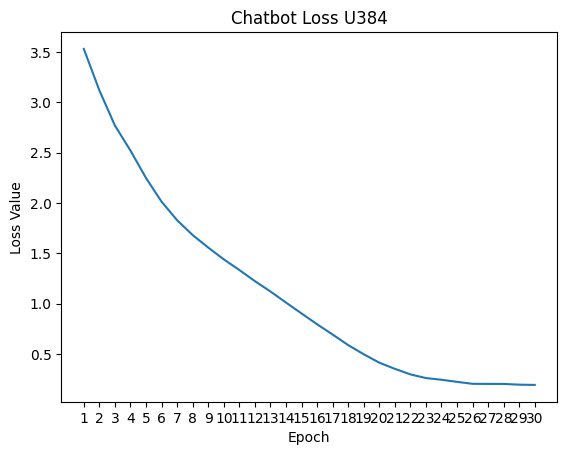

In [ ]:
epochs = list(range(1,EPOCHS+1))
plt.plot(epochs, history.history['loss'], label='loss')
plt.xticks(epochs)
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Chatbot Loss U384')
plt.show()

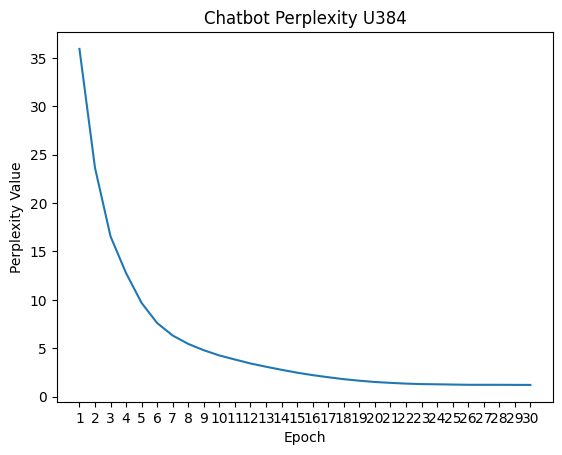

In [ ]:
# perplexity graph

epochs = list(range(1,EPOCHS+1))
plt.plot(epochs, history.history['perplexity'], label='perplexity')
plt.xticks(epochs)
plt.ylabel('Perplexity Value')
plt.xlabel('Epoch')
plt.title('Chatbot Perplexity U384')
plt.show()

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
test_data = [
    {
        "input": "Aku akan mencoba berbicara dengan orang tua ku",
        "reference_responses": [
            "Itu keputusan yang baik! Semoga percakapan itu membantumu menemukan kejelasan. Jika butuh persiapan, aku siap mendengar.",
            "Itu langkah yang sangat berani, dan aku bangga padamu. Berbicara dengan orang tua, apalagi soal perasaan, bisa sangat menegangkan. Tapi itu juga bisa jadi awal dari pemahaman dan koneksi yang lebih sehat. ",
            "Keputusanmu untuk mencoba berbicara adalah bentuk usaha untuk menciptakan hubungan yang lebih sehat. Komunikasi yang jujur sering kali membuka ruang baru yang sebelumnya tertutup. Kamu tidak harus menyelesaikan semuanya dalam satu percakapan cukup mulai dari hati yang tulus.",
            "Aku tahu ini bukan hal yang mudah, jadi aku menghargai niatmu untuk mencoba. Hubungan yang aman dimulai dari keberanian untuk mengungkapkan perasaan, meskipun itu menakutkan. Kalau kamu ingin, kita bisa sama-sama susun kalimat yang ingin kamu ucapkan nanti. ",
            "Komunikasi yang sehat dengan orang tua bisa membuka banyak pintu yang sebelumnya tertutup rapat. Aku percaya kamu bisa menyampaikan isi hatimu dengan cara yang lembut tapi jujur. Aku akan terus ada di sini kalau kamu ingin cerita setelah kamu melakukannya. "
        ]
    },
    {
        "input": "Aku akan mencoba saranmu",
        "reference_responses": [
            "Itu langkah yang baik! Semoga hal itu membantumu merasa lebih tenang. Jangan ragu untuk kembali jika ingin berbicara lebih lanjut.",
            "Aku senang mendengar bahwa kamu ingin mencoba. Memberi ruang untuk mencoba adalah tanda bahwa kamu percaya pada perubahan dan pada dirimu sendiri. Kamu tidak harus langsung berhasil proses pun sudah termasuk bentuk keberanian. ",
            "Keputusanmu untuk mencoba menunjukkan kekuatan dalam dirimu yang kadang mungkin kamu lupakan. Tidak apa-apa jika langkahnya pelan yang penting kamu tahu bahwa kamu tidak sendirian di perjalanan ini. Aku percaya kamu bisa, dan aku ingin tahu seperti apa rasanya setelah kamu mulai. ",
            "Niatmu untuk mencoba sudah jadi langkah yang sangat berarti. Kadang kita belum tahu hasil akhirnya, tapi keberanian untuk mulai itu yang membuka jalan. Aku di sini untuk mendukung dan menemani kamu dalam prosesnya. Kalau kamu butuh bantuan kecil untuk mulai, yuk kita rancang bareng-bareng.",
            "Pilihanmu untuk mencoba bukan hanya langkah ke depan, tapi juga bukti bahwa kamu punya harapan di dalam dirimu. Aku akan selalu ada untuk mendukung setiap usahamu, sekecil apa pun itu. Setelah kamu mencoba, kita bisa evaluasi bareng kalau kamu mau. "
        ]
    },
    {
        "input": "Mengapa saya masih merasa bersalah atas perceraian orang tua saya?",
        "reference_responses": [
            "Merasa bersalah adalah respon emosional yang umum, ketika terjadi perubahan situasi dalam suatu hubungan yang bermakna, misalnya hubungan Anda dengan orang tua. Rasa bersalah itu bisa diturunkan dengan beberapa cara, salah satunya adalah menggunakan perspektif attachment yang positif. Menggunakan perspektif ini, seseorang dapat memposisikan diri untuk menyadari bahwa dia tidak bertanggung jawab atas keputusan orang tua, dan pada saat yang sama meyakini bahwa apapun yang terjadi dalam hubungan antara ayah dan ibu, perasaan kasih sayang mereka kepada anak tetap ada.",
            "Perasaan bersalah yang relatif menetap atas suatu situasi yang sudah cukup lama terjadi bisa disebabkan oleh berbagai faktor. Dalam situasi ketika Anda masih merasa bersalah atas perceraian orang tua, salah satu faktor penyebab yang mungkin adalah karena Anda merasa menjadi faktor yang menyebabkan perceraian tersebut, sedangkan ketika suatu pasangan memutuskan untuk memutuskan hubungan di antara mereka, maka merekalah yang sepenuhnya bertanggung jawab atas keputusan tersebut, bukan orang lain.",
            "Merasa bersalah adalah reaksi yang wajar ketika terjadi perubahan besar dalam hubungan yang bermakna, seperti hubungan dengan orang tua. Dalam perspektif attachment yang positif, seseorang dapat memahami bahwa meskipun hubungan antara orang tua berubah, ikatan emosional dan kasih sayang mereka terhadap anak tetap ada. Dengan membangun pemahaman ini, Anda dapat mengurangi perasaan bertanggung jawab atas perceraian orang tua dan menerima bahwa keputusan mereka adalah bagian dari perjalanan hidup mereka sendiri, bukan sesuatu yang Anda kendalikan.",
            "Perasaan bersalah yang berlarut-larut bisa muncul karena otak berusaha mencari pemahaman atas situasi yang sulit. Dalam konteks attachment, anak yang mengalami perceraian orang tua mungkin merasa bahwa stabilitas emosionalnya terganggu, sehingga mencari cara untuk mengembalikan kendali, salah satunya dengan merasa bersalah. Namun, memahami bahwa setiap individu bertanggung jawab atas pilihannya sendiri dapat membantu membebaskan diri dari perasaan tersebut. Mencari dukungan dari lingkungan yang aman seperti teman, keluarga, atau profesional dapat membantu membentuk kembali persepsi tentang hubungan dan diri sendiri secara lebih sehat.",
            "Saat keluarga mengalami perubahan, seperti perceraian orang tua, fokus pada hubungan yang tetap ada dan memberikan kenyamanan dapat membantu dalam proses penyembuhan. Menyadari bahwa orang tua masih menyayangi Anda, meskipun mereka tidak lagi bersama, dapat memperkuat rasa aman dalam hubungan interpersonal. Anda juga dapat mengembangkan hubungan yang sehat dengan orang-orang di sekitar Anda, yang dapat memberikan dukungan emosional dan membantu Anda melewati perubahan ini dengan lebih baik."
        ]
    },
    {
        "input": "Apakah saya akan bisa menciptakan keluarga yang sehat di masa depan meski berasal dari keluarga yang bercerai?",
        "reference_responses": [
            "Ya, kamu bisa. Asal kamu memiliki kesadaran emosional dan keinginan untuk belajar dari masa lalu, kamu punya kekuatan untuk menciptakan keluarga yang penuh kasih. Attachment positif menunjukkan bahwa pola-pola lama bisa diputuskan dan diganti dengan pola yang lebih sehat. Keluargamu kelak adalah ruang baru yang bisa kamu bentuk dengan cinta dan nilai yang kamu yakini.",
            "Meskipun kamu berasal dari keluarga yang bercerai, kamu tetap punya kapasitas penuh untuk mencintai, dipercaya, dan menciptakan hubungan yang aman. Attachment yang sehat dibentuk dari kesadaran, bukan hanya warisan keluarga. Kamu sudah berada di jalur yang tepat jika kamu mulai mempertanyakan dan memperbaiki pola hubunganmu sekarang. Setiap langkah kecil ke arah kesadaran adalah fondasi bagi keluarga masa depanmu.",
            "Keluarga yang sehat bukan tentang kesempurnaan, tapi tentang kemampuan untuk saling mendengarkan, mengatur emosi, dan hadir satu sama lain. Kamu bisa membangun semua itu meski berasal dari latar belakang yang rumit. Attachment positif percaya bahwa healing itu mungkin, dan kamu bisa menjadi orang tua, pasangan, atau anggota keluarga yang lebih hadir dan sadar. Kamu sedang menyiapkan fondasi itu hari ini.",
            "Pengalaman keluargamu mungkin memberimu luka, tapi juga bisa memberimu kompas untuk tahu apa yang ingin kamu ubah. Dalam attachment positif, kamu tidak ditentukan oleh apa yang dulu, tapi oleh apa yang kamu pilih untuk dilakukan sekarang. Kamu bisa memutus rantai luka dan menggantinya dengan pola yang lebih sehat dan penuh kasih. Harapanmu adalah awal dari perubahan itu.",
            "Jangan ragu akan kemampuanmu menciptakan keluarga yang kamu impikan. Justru karena kamu tahu rasanya tumbuh di tengah ketidaksempurnaan, kamu bisa lebih sadar dan peka saat membangun relasi. Attachment positif memberi keyakinan bahwa keluarga yang sehat bisa lahir dari ketulusan, komunikasi, dan kerja sama. Dan semua itu ada dalam jangkauanmu."

        ]
    },
    {
        "input": "Bagaimana cara menerima bahwa cinta antara orang tua saya sudah berakhir?",
        "reference_responses": [
          "Menerima bahwa cinta orang tua telah berakhir bukan berarti kamu harus menghapus semua kenangan baik tentang mereka. Ini berarti kamu mulai melihat hubungan mereka dengan realitas yang baru, sambil tetap menjaga ruang aman untuk perasaanmu sendiri. Dalam attachment positif, kamu boleh merasakan kesedihan dan kehilangan, sekaligus belajar bahwa cinta bisa berubah bentuk. Kamu tidak kehilangan cinta mereka kepadamu, meskipun mereka sudah tidak bersama lagi.",
          "Wajar jika terasa sulit menerima kenyataan ini, karena cinta orang tua sering menjadi dasar rasa aman kita. Tapi kamu juga sedang belajar bahwa hubungan antar manusia bisa kompleks dan berubah. Attachment yang sehat tidak memaksakan stabilitas semu, melainkan menerima perubahan dengan lembut dan penuh pengertian. Kamu tetap berhak atas cinta dan dukungan, walau bentuk keluargamu telah berubah.",
          "Hubungan orang tua yang berakhir tidak membatalkan semua nilai dan pelajaran yang kamu terima dari mereka. Kadang, menerima kenyataan berarti memberi ruang untuk menyadari bahwa cinta itu tidak hilang ia hanya berpindah bentuk. Dalam attachment positif, kita tidak menyangkal kenyataan, tapi kita memilih berdamai dan tumbuh darinya. Kamu bisa tetap merasakan cinta, meski dengan dinamika keluarga yang baru.",
          "Tak mudah memang ketika yang kita percaya sebagai sesuatu yang abadi, seperti cinta orang tua, ternyata berubah. Tapi bukan berarti kamu kehilangan fondasi hidupmu. Attachment positif mengajarkan bahwa kita bisa tetap membangun rasa aman dengan cara baru dari hubungan yang hadir, dari dirimu sendiri, dan dari koneksi yang kamu jaga. Cinta itu masih ada, bahkan jika wujudnya berubah.",
          "Menerima akhir dari cinta mereka bukan tanda kelemahanmu, tapi kekuatan untuk menatap hidup dengan jujur. Kadang kita butuh waktu untuk memahami bahwa perubahan tidak selalu buruk. Dalam hubungan yang aman, kita diajak untuk memeluk kenyataan tanpa kehilangan harapan. Kamu sedang menata kembali caramu mencintai dan dipedulikan dan itu hal yang luar biasa."

        ]
    },
    {
        "input": "Bagaimana jika saya takut membuka diri karena takut akan ditinggalkan juga?",
        "reference_responses": [
          "Rasa takut ditinggalkan setelah mengalami kehilangan adalah hal yang sangat manusiawi. Attachment positif mengajarkan bahwa rasa aman bisa dibangun secara perlahan, bukan dipaksakan. Kamu boleh mengambil waktu, dan kamu tidak harus langsung percaya sepenuhnya. Yang penting, kamu tetap memberi dirimu kesempatan untuk terhubung, meski dengan hati-hati.",
          "Takut membuka diri bukan berarti kamu lemah, tapi justru menunjukkan bahwa hatimu punya kedalaman. Dalam hubungan yang aman, kamu tidak harus sempurna atau selalu kuat untuk dicintai. Orang yang tepat akan menghargai prosesmu dan tidak terburu-buru memintamu menyerahkan semua. Kamu berhak merasa aman sebelum membuka pintu hatimu lebih jauh.",
          "Ketakutan ditinggalkan bisa berasal dari pengalaman masa lalu yang belum sempat kamu sembuhkan. Attachment positif menyarankan untuk membangun hubungan perlahan-lahan, mulai dari ruang-ruang kecil yang aman. Kamu bisa mulai dengan berbagi sedikit demi sedikit, dan menghargai keberanianmu setiap kali kamu jujur. Koneksi yang tumbuh dari kepercayaan akan jauh lebih tahan lama.",
          "Kamu tidak salah karena hati-hati itu artinya kamu belajar dari pengalaman. Tapi kamu juga tidak harus membiarkan ketakutan terus-menerus menghalangi peluang untuk dicintai dengan tulus. Dalam dunia yang penuh ketidakpastian, hubungan yang sehat justru tumbuh dari keberanian membuka diri meski ada resiko terluka. Kamu tidak sendiri, dan kamu bisa mulai dari langkah kecil hari ini.",
          "Kamu mungkin pernah merasa ditinggalkan, dan rasa itu begitu membekas hingga kini. Tapi attachment yang sehat mengingatkan bahwa tidak semua hubungan akan berakhir seperti itu. Ada orang-orang yang akan tinggal, bahkan ketika kamu tidak dalam kondisi terbaikmu. Kamu layak dicintai apa adanya, termasuk saat kamu belum sepenuhnya yakin untuk membuka diri."

        ]
    },
    {
        "input": "Aku merasa overthinking",
        "reference_responses": [
           "Terkadang pikiran kita bisa terasa begitu penuh, ya. Apa hal yang paling sering muncul di pikiranmu akhir-akhir ini?",
           "Overthinking sering kali muncul saat otak kita merasa tidak aman dan mencoba mencari kontrol di tengah ketidakpastian. Itu adalah reaksi alami dari seseorang yang sangat peduli dan ingin melakukan hal dengan benar. Tapi kamu tidak harus memikirkan semuanya sendiri. Apakah kamu ingin bercerita tentang hal apa yang paling sering kamu ulang-ulang dalam pikiranmu?",
           "Saat kamu merasa overthinking, itu bisa menjadi tanda bahwa ada sesuatu yang belum kamu beri ruang untuk dipahami secara emosional, bukan hanya secara logika. Dalam hubungan yang aman, kamu bisa berbagi tanpa takut dinilai atau disalahkan. Aku di sini untuk menemani kamu memisahkan mana yang nyata dan mana yang hanya kekhawatiran. Apa hal yang paling membuatmu merasa cemas akhir-akhir ini?",
           "Pikiran yang terus berputar bisa membuat kamu merasa lelah, dan itu wajar. Overthinking sering kali datang dari tempat di mana kita pernah merasa kecewa atau kehilangan, dan sekarang otakmu mencoba melindungimu. Tapi kamu tidak sendiri dalam menghadapi ini. Apa yang paling sering kamu pikirkan berulang-ulang hingga membuatmu sulit tenang?",
           "Dalam positive attachment, kita belajar bahwa pikiran yang terus-menerus muncul biasanya adalah ekspresi dari rasa takut yang belum diproses sepenuhnya. Mungkin ada cerita atau pengalaman yang terasa belum selesai. Aku di sini kalau kamu ingin pelan-pelan menceritakannya. Apakah kamu merasa ada sesuatu yang tidak bisa kamu kendalikan akhir-akhir ini?"
        ]
    },
    {
        "input": "Aku merasa sangat sedih",
        "reference_responses": [
           "Aku di sini untukmu. Aku tahu semua yang sedang kamu pikirkan dan rasakan itu berat, dan tidak apa-apa kalau kamu merasa sedih. Kamu tidak sendirian dalam hal ini. Aku ingin mendengarkan, kalau kamu ingin bercerita. Apa yang paling membebanimu saat ini?",
           "Kesedihan yang kamu rasakan valid dan penting untuk dikenali. Dalam hubungan yang aman secara emosional, kita punya ruang untuk menangis dan merasa lemah tanpa harus merasa dihakimi. Kadang, perasaan sedih itu tidak datang begitu saja ada cerita di baliknya. Bolehkah aku tahu, hal apa yang sedang kamu rindukan atau khawatirkan saat ini?",
           "Kesedihan bisa terasa sangat menyesakkan, apalagi jika kamu merasa harus menahannya sendiri. Tapi kamu tidak sendiri sekarang. Aku ingin menemani, dan mungkin kita bisa pelan-pelan membuka cerita yang membuat hatimu terasa berat. Apakah ada sesuatu yang membuatmu merasa kehilangan atau tidak dimengerti akhir-akhir ini?",
           "Perasaan sedih sering kali muncul saat kita menghadapi perubahan atau kehilangan dalam hubungan penting dalam hidup kita. Perasaan itu layak mendapat ruang untuk diakui dan dipahami. Aku penasaran, apakah ada momen terakhir yang terasa sangat berat untukmu?",
           "Saat kita merasa sedih, yang paling dibutuhkan adalah koneksi yang aman tempat untuk merasa diterima apa adanya. Aku di sini untuk menciptakan ruang itu untukmu. Kamu bisa cerita sebanyak atau sesedikit yang kamu mau. Hal apa yang paling kamu harap bisa berjalan berbeda belakangan ini?"
        ]
    },
    {
        "input": "Kapan aku bisa keluar dari perasaan ini?",
        "reference_responses": [
            "Proses menyembuhkan perasaan memang membutuhkan waktu. Apa yang biasanya membuatmu merasa seperti ini?",
            "Perasaan ini tidak akan bertahan selamanya, meski saat ini terasa begitu berat. Waktu memang membantu, tapi yang juga penting adalah bagaimana kita merawat diri dan mencari dukungan. Dalam hubungan yang aman, kita bisa mulai menemukan jalan keluar bersama, perlahan-lahan. Apa yang paling kamu butuhkan sekarang agar hari ini terasa sedikit lebih ringan?",
            "Rasa sakit ini tidak selamanya, meskipun rasanya seperti itu. Hal yang penting adalah kamu tidak harus menunggu semuanya hilang untuk merasa lebih baik; kamu bisa mulai merasa sedikit lega dengan berbagi. Kalau kamu nyaman, aku ingin dengar cerita tentang apa yang kamu rindukan dari masa-masa sebelum perasaan ini muncul.",
            "Keluar dari perasaan ini adalah proses yang dimulai dengan keberanian untuk bertanya, seperti yang baru saja kamu lakukan. Dalam attachment yang aman, kamu tidak harus melewatinya sendiri. Aku ingin tahu, langkah kecil apa yang menurutmu bisa membantu dan apa yang menghalanginya sejauh ini?",
            "Dalam hubungan yang sehat, pemulihan terjadi karena ada yang menemani bukan hanya karena waktu berlalu. Aku percaya kamu bisa melewati ini dengan dukungan dan pengertian yang tepat. Apa satu hal kecil yang bisa kamu lakukan hari ini yang mungkin membawa sedikit harapan?"
        ]
    },
]


In [ ]:
def evaluate_model_scores(model, test_data):
    # Initialize lists to store model predictions and reference answers
    hypotheses = []
    references = []

    # Iterate over each item in the test set
    for item in test_data:
        user_input = item["input"]  # The input message to the chatbot
        reference_outputs = item["reference_responses"]  # List of expected (ground truth) responses

        predicted = predict_with_model(model, user_input)  # Get model's response

        hypotheses.append(predicted)  # Store model's prediction
        references.append(reference_outputs)  # Store ground truth reference list

    bleu_scores = []     # Will hold BLEU scores per sample
    meteor_scores = []   # Will hold METEOR scores per sample

    # Evaluate BLEU and METEOR for each prediction-reference pair
    for ref_list, hyp in zip(references, hypotheses):
        # --- BLEU SCORE CALCULATION ---
        # BLEU works at the token level; encode hypothesis into tokens
        hyp_tokens = tokenizer.encode(hyp)

        # Encode each reference response into tokens
        ref_token_lists = [tokenizer.encode(ref) for ref in ref_list]

        # Compute sentence-level BLEU using smoothing to avoid zero scores
        # SmoothingFunction().method1 avoids score = 0 for short predictions
        bleu = sentence_bleu(ref_token_lists, hyp_tokens, smoothing_function=SmoothingFunction().method1)
        bleu_scores.append(bleu)

        # --- METEOR SCORE CALCULATION ---
        # METEOR works at the word level
        hyp_words = hyp.split()  # Split hypothesis into words
        ref_words_list = [ref.split() for ref in ref_list]  # List of reference responses split into words

        # Compute METEOR score against each reference, and keep the best one
        # This handles multiple valid references for one input
        meteor = max([single_meteor_score(ref_words, hyp_words) for ref_words in ref_words_list])
        meteor_scores.append(meteor)

    # Compute average BLEU and METEOR scores across all test samples
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_meteor = sum(meteor_scores) / len(meteor_scores)

    # Print results
    print(f"📘 Average BLEU score: {avg_bleu:.4f}")
    print(f"📙 Average METEOR score: {avg_meteor:.4f}")

    # Return average scores for further use
    return avg_bleu, avg_meteor


In [ ]:
print("Evaluating Model lightweight")
bleu_A, meteor_A = evaluate_model_scores(model_lw, test_data)

In [ ]:
#NUM LAYER Model
model_NL2.load_weights('D:/skripsi-sultin/data/bot_v4_Final_NL2_E50.weights.h5')
model_NL3.load_weights('D:/skripsi-sultin/data/bot_v4_Final_NL3_E50.weights.h5')
model_NL4.load_weights('D:/skripsi-sultin/data/bot_v4_Final_NL4_E50.weights.h5')
model_NL5.load_weights('D:/skripsi-sultin/data/bot_v4_Final_NL5_E50.weights.h5')
#Dropout Model
model_D015.load_weights('D:/skripsi-sultin/data/bot_v4_Final_D015_E50.weights.h5')
model_D02.load_weights('D:/skripsi-sultin/data/bot_v4_Final_D02_E50.weights.h5')
model_D025.load_weights('D:/skripsi-sultin/data/bot_v4_Final_NH16_D025.weights.h5')
#Unit Model
model_U384.load_weights('D:/skripsi-sultin/data/bot_v4_Final_U384_E50.weights.h5')
model_U640.load_weights('D:/skripsi-sultin/data/bot_v4_Final_U640_E50.weights.h5')
model_U256.load_weights('D:/skripsi-sultin/data/bot_v4_Final_U256_E50.weights.h5')
#Dim Model
model_DM128.load_weights('D:/skripsi-sultin/data/bot_v4_Final_DM128_E50.weights.h5')
model_DM328.load_weights('D:/skripsi-sultin/data/bot_v4_Final_DM328_E50.weights.h5')
model_DM512.load_weights('D:/skripsi-sultin/data/bot_v4_Final_DM512_E50.weights.h5')
#Dim Model
model_NH4.load_weights('D:/skripsi-sultin/data/bot_v4_Final_NH4_E50.weights.h5')
model_NH16.load_weights('D:/skripsi-sultin/data/bot_v4_Final_NH16_E50.weights.h5')
model_NH32.load_weights('D:/skripsi-sultin/data/bot_v4_Final_NH32_E50.weights.h5')

In [ ]:
print("==========================")
print("Evaluating Model NUM LAYER")
print("Evaluating Model NL2")
bleu_NL2, meteor_NL2 = evaluate_model_scores(model_NL2, test_data)
print("Evaluating Model NL3")
bleu_NL3, meteor_NL3 = evaluate_model_scores(model_NL3, test_data)
print("Evaluating Model NL4")
bleu_NL4, meteor_NL4 = evaluate_model_scores(model_NL4, test_data)
print("Evaluating Model NL5")
bleu_NL5, meteor_NL5 = evaluate_model_scores(model_NL5, test_data)
print("==========================")
print("Evaluating Model Dropout")
print("Evaluating Model D015")
bleu_D015, meteor_D015 = evaluate_model_scores(model_D015, test_data)
print("Evaluating Model D02")
bleu_D02, meteor_D02 = evaluate_model_scores(model_D02, test_data)
print("Evaluating Model D025")
bleu_D025, meteor_D025 = evaluate_model_scores(model_D025, test_data)
print("==========================")
print("Evaluating Model Unit")
print("Evaluating Model U384")
bleu_U384, meteor_U384 = evaluate_model_scores(model_U384, test_data)
print("Evaluating Model U640")
bleu_U640, meteor_U640 = evaluate_model_scores(model_U640, test_data)
print("Evaluating Model U256")
bleu_U256, meteor_U256 = evaluate_model_scores(model_U256, test_data)
print("==========================")
print("Evaluating Model Dim")
print("Evaluating Model DM128")
bleu_DM128, meteor_DM128 = evaluate_model_scores(model_DM128, test_data)
print("Evaluating Model DM328")
bleu_DM328, meteor_DM328 = evaluate_model_scores(model_DM328, test_data)
print("Evaluating Model DM512")
bleu_DM512, meteor_DM512 = evaluate_model_scores(model_DM512, test_data)
print("==========================")
print("Evaluating Model NUM HEAD")
print("Evaluating Model NH4")
bleu_NH4, meteor_NH4 = evaluate_model_scores(model_NH4, test_data)
print("Evaluating Model NH16")
bleu_NH16, meteor_NH16 = evaluate_model_scores(model_NH16, test_data)
print("Evaluating Model NH32")
bleu_NH32, meteor_NH32 = evaluate_model_scores(model_NH32, test_data)
print("==========================")

Evaluating Model NUM LAYER
Evaluating Model NL2
ERROR! Session/line number was not unique in database. History logging moved to new session 56
Input: Aku akan mencoba berbicara dengan orang tua ku
Output: Itu keputusan yang baik ! Semoga percakapan menemukan kejelasan . Berbicara dengan orang tua , aku soal perasaan , bukan sesuatu yang pernah membuatmu merasa lebih dewasa dari sebelumnya . Dalam perspektif attachment yang positif , rasa aman bisa menjadi langkah kecil yang sebelumnya tertutup . Kamu tetap punya tempat yang siap mendengarkan dan berbagi sedikit dari langkah yang tulus .
Input: Aku akan mencoba saranmu
Output: Itu langkah yang baik ! Semoga hal membantumu menemukan kejelasan . Jika butuh persiapan , aku siap mendengar .
Input: Mengapa saya masih merasa bersalah atas perceraian orang tua saya?
Output: Merasa bersalah adalah reaksi yang wajar ketika terjadi perubahan besar dalam rutinitas dan bermakna , seperti hubungan dengan orang tua . Dalam perspektif attachment yang 

In [ ]:
#Final Model based on experiments Hypereparameters
NUM_LAYERS = 3
D_MODEL = 328
NUM_HEADS = 8
UNITS = 384
DROPOUT = 0.15

model_final = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)


model_final.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=[accuracy, perplexity],
    run_eagerly=True  # Set to True for debugging if needed
)

In [ ]:
epoch = 30
history = model_final.fit(dataset, epochs=epoch)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.0186 - loss: 3.0367 - perplexity: 22.4110
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.0229 - loss: 2.8791 - perplexity: 18.1006
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.0217 - loss: 2.8144 - perplexity: 16.9679
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.0213 - loss: 2.8122 - perplexity: 16.8766
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.0221 - loss: 2.7455 - perplexity: 15.8802
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.0214 - loss: 2.7499 - perplexity: 16.0000
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.0218 - loss: 2.7999 - perplexity: 16.6608
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.0213 - loss: 2.7692 - perplexity: 16.2717
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.0218 - loss: 2.8291 - perplexity: 17.2023
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/

In [ ]:
model_final.save_weights('D:/skripsi-sultin/data/bot_v3_Final_Konfigurasi.weights.h5')

In [ ]:
model_U384.load_weights('D:/skripsi-sultin/data/bot_v3_Final_Konfigurasi.weights.h5')

In [ ]:
print("Evaluating Model final")
bleu_final, meteor_final = evaluate_model_scores(model_final, test_data)

Evaluating Model final
Input: Aku akan mencoba berbicara dengan orang tua ku
Output: Aku tahu ini bukan hal yang mudah , jadi aku menghargai niatmu untuk mencoba . Hubungan yang aman dimulai dari keberanian untuk mengungkapkan perasaan , meskipun itu menakutkan . Kalau kamu ingin , kita bisa sama susun kalimat yang nyaman , seperti itu . Kalau kamu ucapkan nanti .
Input: Aku akan mencoba saranmu
Output: Keputusanmu untuk mencoba menunjukkan kekuatan dalam dirimu yang kadang mungkin kamu lupakan . Tidak apa jika langkahnya pelan yang penting kamu tahu bahwa kamu belum tahu tidak sendirian di perjalanan ini . Aku percaya kamu bisa , dan aku ingin tahu seperti apa rasanya setelah kamu mulai .
Input: Mengapa saya masih merasa bersalah atas perceraian orang tua saya?
Output: Perasaan bersalah yang berlarut larut bisa muncul karena otak berusaha mencari pemahaman atas situasi yang sulit . Dalam konteks attachment , anak yang mengalami perceraian orang tua mungkin merasa bahwa stabilitas emos

In [ ]:
model_U384.load_weights('D:/skripsi-sultin/data/bot_v3_Final_U384.weights.h5')

In [ ]:
print("Evaluating Model U384")
bleu_U384, meteor_U384 = evaluate_model_scores(model_U384, test_data)

Evaluating Model U384
Input: Aku akan mencoba berbicara dengan orang tua ku
Output: Komunikasi yang sehat dengan orang tua bisa membuka banyak pintu yang sebelumnya tertutup rapat . Aku percaya kamu bisa menyampaikan isi hatimu dengan cara yang lembut tapi jujur . Aku akan terus ada di sini kalau kamu ingin cerita setelah kamu melakukannya .
Input: Aku akan mencoba saranmu
Output: Keputusanmu untuk mencoba menunjukkan kekuatan dalam dirimu yang kadang mungkin kamu lupakan . Tidak apa apa apa apa apa apa apa apa apa apa apa apa apa jika kamu rasakan . Apa di sini kalau kamu ingin berbicara buruk satu sama lain ?
Input: Mengapa saya masih merasa bersalah atas perceraian orang tua saya?
Output: Perasaan bersalah yang berlarut larut bisa muncul karena otak berusaha mencari pemahaman atas situasi yang sulit . Dalam konteks attachment , anak yang mengalami perceraian orang tua mungkin merasa bahwa stabilitas emosionalnya terganggu , sehingga mencari cara untuk mengembalikan kendali , salah s

Gradio

In [ ]:
model_final.load_weights('D:/skripsi-sultin/data/bot_v3_Final_NH8_E50.weights.h5')

In [ ]:
print("Evaluating Model final")
bleu_NH4, meteor_NH4 = evaluate_model_scores(model_final, test_data)

Evaluating Model final
Input: Aku akan mencoba berbicara dengan orang tua ku
Output: Keputusanmu untuk mencoba berbicara adalah bentuk usaha untuk menciptakan hubungan yang lebih sehat . Komunikasi yang jujur sering kali membuka ruang baru yang jujur dan tanpa menekan emosi . Aku percaya kamu bisa jadi langkah awal dari pemahaman dan menerima perubahan yang lebih sehat . Kamu berhak menciptakan ruang bagi diri sendiri untuk menciptakan ruang bagi yang lebih dulu .
Input: Aku akan mencoba saranmu
Output: Keputusanmu untuk mencoba menunjukkan kekuatan dalam dirimu yang kadang mungkin kamu lupakan . Tidak apa apa apa apa apa apa apa apa jika langkahnya pelan yang penting bagi kamu tidak harus hilang di perjalanan ini . Aku percaya kamu ingin tahu bahwa kamu mulai , dan tetap punya dukungan dan koneksi yang kamu ingin tahu rasanya setelah kamu alami .
Input: Mengapa saya masih merasa bersalah atas perceraian orang tua saya?
Output: Merasa bersalah adalah respon emosional yang umum , ketika